In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
#Importing neccessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
#Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
  print('GPU is being used.')
else:
  print('GPU is not being used')

GPU is being used.


In [4]:
# path to the dataset
#dataset_path = "/kaggle/working/animal-image-dataset-90-different-animals" #Original path causing the error
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals" #Corrected path pointing to the downloaded dataset location


# list of all classes(Animal type)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# display the no of classes along with names
print(f"Number of classes: {num_classes}")
print(f"Class names: {classes}")


Number of classes: 90
Class names: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


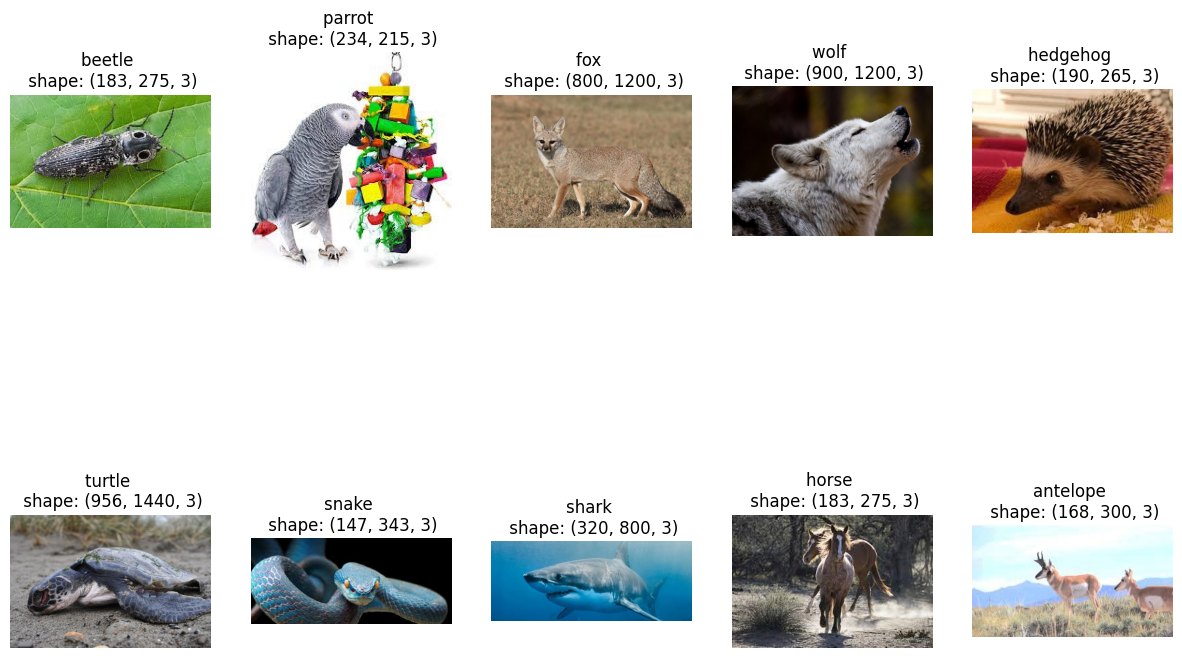

In [5]:
# Visualize some sample images form the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [6]:
#preprocessing the data.
#Define image size and batch_size-Trained model - MobileNetV2-224 * 224
img_size = (224, 224)
batch_size = 64 #there can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

#create traning and validation generation
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size= batch_size,
    class_mode='categorical',
    subset='training'

)
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [7]:
#Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)

#Extract class names
class_names =list(class_indices.keys())
print("Class_Names:",class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [8]:
#load MobileNetV2 as the Same model
base_model = MobileNetV2 (
    weights ='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

#Freeze the base model weights,training
base_model.trainable = False

#Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes , activation='softmax')(x) #output layer

#Create final model
model = Model(inputs=base_model.input, outputs=predictions)

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

 # Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 895ms/step - accuracy: 0.3365 - loss: 3.1335 - val_accuracy: 0.8008 - val_loss: 0.7988
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7031 - loss: 1.0142

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7031 - loss: 1.0142 - val_accuracy: 0.7871 - val_loss: 0.7996
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 490ms/step - accuracy: 0.8376 - loss: 0.6135 - val_accuracy: 0.8203 - val_loss: 0.6949
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8594 - loss: 0.5145 - val_accuracy: 0.8262 - val_loss: 0.6791
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 487ms/step - accuracy: 0.8928 - loss: 0.3652 - val_accuracy: 0.8301 - val_loss: 0.6603
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8750 - loss: 0.5023 - val_accuracy: 0.8301 - val_loss: 0.6630
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9210 - loss: 0.2551 - val_accuracy: 0.8496 - val_loss: 0.5341
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8281 - loss: 0.4342 - val_accuracy: 0.8457 - val_loss: 0.5823
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.9619 - loss: 0.1516 - val_accuracy: 0.8379 - val_

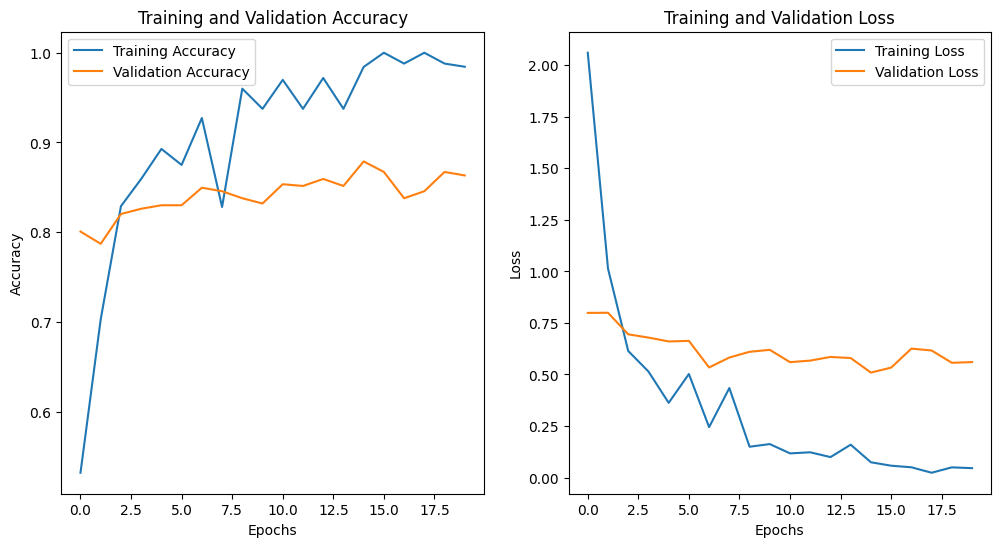

In [14]:
#Evaluate the model -plotting the training and validation acc/loss
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
#Evalute the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy:{val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step - accuracy: 0.8655 - loss: 0.5724
Validation Loss: 0.5553690791130066
Validation Accuracy:0.8666666746139526


In [16]:
#Save the model
model.save('MCAR.keras')

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [23]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/antelope')

['72e3e735f7.jpg',
 '7e12bc4942.jpg',
 '27d251fa65.jpg',
 '0ee903ea13.jpg',
 '2d2dd75fb8.jpg',
 'fc6545699d.jpg',
 '24b29ea96e.jpg',
 '17ddf07f85.jpg',
 '8b1539144f.jpg',
 '82e0981104.jpg',
 '41f6b61453.jpg',
 'fc1dd26858.jpg',
 '27a5369441.jpg',
 '9e39fc9334.jpg',
 '0c16ef86c0.jpg',
 '1a3f59ee02.jpg',
 '65fd7f96e5.jpg',
 '73c2ef82e2.jpg',
 '6aa06f252d.jpg',
 'fd085737a4.jpg',
 '0a37838e99.jpg',
 '02f4b3be2d.jpg',
 '9a58695d48.jpg',
 '1d3c6105c9.jpg',
 '0b1a3af197.jpg',
 '34e5155c46.jpg',
 '058fa9a60f.jpg',
 '61f99c8534.jpg',
 '9b9623816d.jpg',
 '54a58b5f0a.jpg',
 '0fe7076f06.jpg',
 '0e17715606.jpg',
 '4e5b190ff0.jpg',
 '8bab6ca1d3.jpg',
 '1db1ad56e5.jpg',
 '71e7414274.jpg',
 '68eb12a751.jpg',
 '6cd126d1c1.jpg',
 '03d7fc0888.jpg',
 '2efa7906c2.jpg',
 '9b08d5d668.jpg',
 '17a07512e9.jpg',
 '61c60311b5.jpg',
 '41d70d1f6b.jpg',
 '6b26150e67.jpg',
 'fab6e81536.jpg',
 '1b0b0b614b.jpg',
 '6fb2619e84.jpg',
 '7cf6c0e8c0.jpg',
 '3a3ea34fb6.jpg',
 '0b688923b0.jpg',
 '8a55e17288.jpg',
 '1d556456dc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


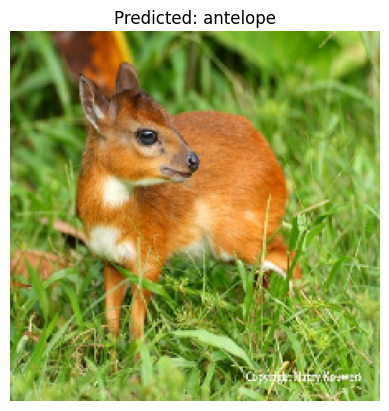

In [27]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/antelope/61f99c8534.jpg')